<a href="https://colab.research.google.com/github/KylerCWK/RateFunction-/blob/main/RateFunction%20matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

******************************
Keep it simple

What function do you want?: x^2
Enter the first inverval (intager): 4
Enter the second interval (intager): 8
the average velocity from 4 and 8 is: 12.0


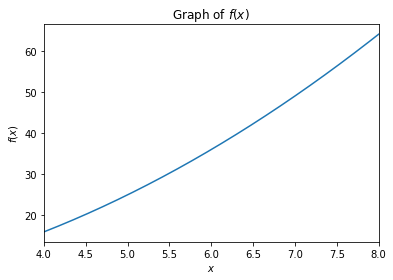

In [ ]:
#Kyler Gelissen
#9/2/2022
#Math 181
#This was so painful to write and got some huge help from libs in pyparsing 

from __future__ import division
from pyparsing import (Literal, CaselessLiteral, Word, Combine, Group, Optional,
                       ZeroOrMore, Forward, nums, alphas, oneOf)

'''
author = 'Paul McGuire'
source = https://github.com/pyparsing/pyparsing/blob/master/examples/fourFn.py
'''
import math
import operator

import matplotlib.pyplot as plt
import numpy as np
import re
plt.close()

replacements = {
    'sin' : 'np.sin',
    'cos' : 'np.cos',
    'exp': 'np.exp',
    'sqrt': 'np.sqrt',
    '^': '**',
}

allowed_words = [
    'x',
    'sin',
    'cos',
    'sqrt',
    'exp',
]


class NumericStringParser(object):
    
    #Most of this code comes from the fourFn.py pyparsing example
  
    def pushFirst(self, strg, loc, toks):
        self.exprStack.append(toks[0])

    def pushUMinus(self, strg, loc, toks):
        if toks and toks[0] == '-':
            self.exprStack.append('unary -')

    def __init__(self):
        """
        expop   :: '^'
        multop  :: '*' | '/'
        addop   :: '+' | '-'
        integer :: ['+' | '-'] '0'..'9'+
        atom    :: PI | E | real | fn '(' expr ')' | '(' expr ')'
        factor  :: atom [ expop factor ]*
        term    :: factor [ multop factor ]*
        expr    :: term [ addop term ]*
        """
        #Bunch of literals that check if values are present.
        #Ex. Literal("foo").parseString() #Given (qwdiwjdfoo223912) --> #Output foo
        point = Literal(".")
        e = CaselessLiteral("E")
        #Checks both sides of the + or - sign for the number/word
        fnumber = Combine(Word("+-" + nums, nums) +
                          Optional(point + Optional(Word(nums))) +
                          Optional(e + Word("+-" + nums, nums)))
        ident = Word(alphas, alphas + nums + "_$")
        plus = Literal("+")
        minus = Literal("-")
        mult = Literal("*")
        div = Literal("/")
        lpar = Literal("(").suppress()
        rpar = Literal(")").suppress()
        addop = plus | minus
        multop = mult | div
        expop = Literal("^")
        pi = CaselessLiteral("PI")
        expr = Forward()
        #Grouping method
        atom = ((Optional(oneOf("- +")) +
                 (ident + lpar + expr + rpar | pi | e | fnumber).setParseAction(self.pushFirst))
                | Optional(oneOf("- +")) + Group(lpar + expr + rpar)
                ).setParseAction(self.pushUMinus)
        # by defining exponentiation as "atom [ ^ factor ]..." instead of
        # "atom [ ^ atom ]...", we get right-to-left exponents, instead of left-to-right
        # that is, 2^3^2 = 2^(3^2), not (2^3)^2.
        factor = Forward()
        factor << atom + \
            ZeroOrMore((expop + factor).setParseAction(self.pushFirst))
        term = factor + \
            ZeroOrMore((multop + factor).setParseAction(self.pushFirst))
        expr << term + \
            ZeroOrMore((addop + term).setParseAction(self.pushFirst))
        # addop_term = ( addop + term ).setParseAction( self.pushFirst )
        # general_term = term + ZeroOrMore( addop_term ) | OneOrMore( addop_term)
        # expr <<  general_term
        self.bnf = expr
        # map operator symbols to corresponding arithmetic operations
        epsilon = 1e-12
        self.opn = {"+": operator.add,
                    "-": operator.sub,
                    "*": operator.mul,
                    "/": operator.truediv,
                    "^": operator.pow}
        '''
        self.fn = {"sin": math.sin,
                   "cos": math.cos,
                   "tan": math.tan,
                   "exp": math.exp,
                   "sqrt": math.sqrt,
                   "abs": abs,
                   "trunc": lambda a: int(a),
                   "round": round,
                   "sgn": lambda a: abs(a) > epsilon and cmp(a, 0) or 0}
      '''

    # A beefed up hybrid lookup table 
    def evaluateStack(self, s): 
        op = s.pop()
        if op == 'unary -':
            return -self.evaluateStack(s)
        if op in "+-*/^":
            op2 = self.evaluateStack(s)
            op1 = self.evaluateStack(s)
            return self.opn[op](op1, op2)
        elif op == "PI":
            return math.pi  # 3.1415926535
        elif op == "E":
            return math.e  # 2.718281828
        #elif op in self.fn:
            #return self.fn[op](self.evaluateStack(s))
        elif op[0].isalpha(): #if the operation is in the alphabet returns nothing
            return 0
        else:
            return float(op)

    def eval(self, num_string, parseAll=True):
        self.exprStack = []
        results = self.bnf.parseString(num_string, parseAll)
        val = self.evaluateStack(self.exprStack[:])
        return val

#Creates the object nsp
nsp = NumericStringParser()

#Defines the graph plotting class
#This acts weird in a class :(

def graph_StringToFunc(string):
    #evaluates the string and returns a function of x
    # find all words and check if all are allowed:
    for word in re.findall('[a-zA-Z_]+', string):
        if word not in allowed_words:
            raise ValueError(
                '"{}" is forbidden to use in math expression'.format(word)
            )

    for old, new in replacements.items():
        string = string.replace(old, new)

    def func(x):
        return eval(string)

    return func

#Evaluates string
def getFunction(funct):
  funct_list = [i for a,i in enumerate(funct)]
  funct_string = " ".join([str(item) for item in funct_list])
  return nsp.eval(funct_string)


#Makes the string to a list that replaces all "x"'s with input number
#returns list to string and is evaluated by the nsp and is returned
def f(x, fib):
  f_list = [i for a,i in enumerate(fib)]
  #getFunction(fib)
  for i, n in enumerate(f_list):
    if n == 'x':
      f_list[i] = x
  #print(f"This is f_list: {f_list}")
  f_string = " ".join([str(item) for item in f_list])
  return nsp.eval(f_string)

#Creates the average velocity function with a and b parameters
def average_vel(a,b,funct):
  #Crashes when you condense this so idk
  x = f(b,funct) - f(a,funct)
  z = b - a
  return x/z      #(f(b,funct) - f(a,funct))/b - a


#Asks for user input for both numbers
if __name__ == "__main__":
  print("******************************")
  print("Keep it simple")
  print()
  function_input = input("What function do you want?: ")

  fst_num = int(input("Enter the first inverval (intager): "))
  sec_num = int(input("Enter the second interval (intager): "))

  
  func = graph_StringToFunc(function_input)
  a = float(fst_num)
  b = float(sec_num)
  x = np.linspace(a, b, 250)

  #Prints results
  print(f"the average velocity from {fst_num} and {sec_num} is: {average_vel(fst_num, sec_num, function_input)}")

  plt.plot(x, func(x))
  plt.title('Graph of $f(x)$')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.xlim(a, b)
  plt.show()




  

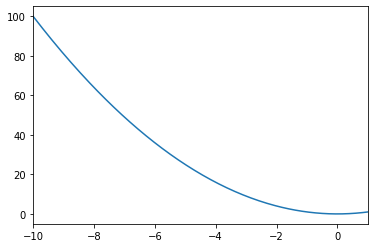

In [ ]:
#Matplotlib implementation 
#Kyler Gelissen
#9/9/2022 (rip queen)

import re
import matplotlib as plt 

replacements = {
    'sin' : 'np.sin',
    'cos' : 'np.cos',
    'exp': 'np.exp',
    'sqrt': 'np.sqrt',
    '^': '**',
}

allowed_words = [
    'x',
    'sin',
    'cos',
    'sqrt',
    'exp',
]

def graph_StringToFunc(string):
    #evaluates the string and returns a function of x
    # find all words and check if all are allowed:
    for word in re.findall('[a-zA-Z_]+', string):
        if word not in allowed_words:
            raise ValueError(
                '"{}" is forbidden to use in math expression'.format(word)
            )

    for old, new in replacements.items():
        string = string.replace(old, new)

    def func(x):
        return eval(string)

    return func


test_function = "x^2"
limit_1 = "-10"
limit_2 = "1"

if __name__ == '__main__':

    func = graph_StringToFunc(test_function)
    a = float(limit_1)
    b = float(limit_2)
    x = np.linspace(a, b, 250)

    #plt.axvline(x = a, color ='red')
    #plt.axvline(x = b, color ='orange')

    plt.plot(x, func(x))
    plt.xlim(a, b)
    plt.show()



#op = {'+': lambda x, y: x + y,
      #'-': lambda x, y: x - y,
      #'*': lambda x, y: x * y,
      #'^': lambda x,y: x ** y,
      #'/': lambda x, y: x / y}
